In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import shutil

import tensorflow as tf
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Using TensorFlow backend.


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128 # розмір пікселів в ширину на зображенні
IMAGE_HEIGHT=128 # розмір пікселів в висоту на зображенні
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT) # розмір фотографії
IMAGE_CHANNELS=3 # RGB

In [3]:
path = '/home/artur/Downloads/dc/train/' # шлях до фотографій
filenames = os.listdir(path) # перелік файлів (зображень) які знаходяться в цій папці
categories = [] # створюємо список, в який буде класифікувати фотографії для тренування нейронної мережі
for filename in filenames: # цикл по яку буде прозодитись по фотографіям
    category = filename.split('.')[0] # .split('.') - розбиваємо крапками назву фотографії на список і беремо 0 елемент, тобто cat/dog
    if category == 'dog': # якщо це собака, то добавляємо в список 1
        categories.append(1)
    else: # якщо це кіт, то добавляємо в список 0
        categories.append(0)
    
    
df = pd.DataFrame({ # створюємо таблицю
    'filename': filenames, # filename - назва фотографії
    'category': categories # category - 1(dog) / 0(cat) 
})

In [4]:
df.head() # посаток таблиці

,filename,category
0,cat.3525.jpg,0
1,dog.3129.jpg,1
2,cat.6944.jpg,0
3,cat.7095.jpg,0
4,cat.10370.jpg,0


In [5]:
df.tail() # кінець таблиці

,filename,category
24995,dog.9553.jpg,1
24996,cat.9849.jpg,0
24997,dog.4662.jpg,1
24998,dog.6830.jpg,1
24999,cat.8072.jpg,0


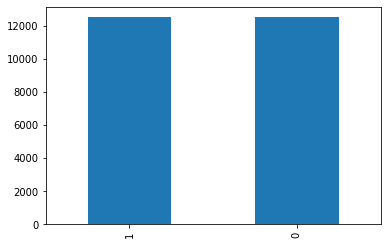

In [6]:
df['category'].value_counts().plot.bar() # Виводимо графічно скільки в нас є даних

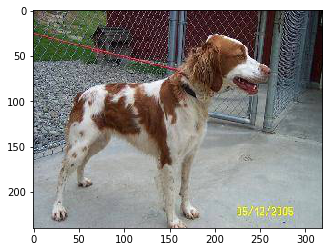

In [7]:
sample = random.choice(filenames) 
image = load_img(path + sample)
plt.imshow(image)

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# 32 - фільтри, (3, 3) - ядро фільтра(матриця), activation='relu' - функція активації, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS) - вхідні данні
model.add(BatchNormalization()) # нормалізуємо активацію попереднього шару на кожній партії, тобто застосовуємо перетворення, яке підтримує середню активацію близько до 0 і стандартне відхилення активації близьке до 1.пакетна нормалізація дозволяє кожному шару мережі навчитися самостійно трохи більше незалежно від інших шарів.
model.add(MaxPooling2D(pool_size=(2, 2))) # вибирає найголовніші пікселі(найбілше значення) і зменшує зображення
model.add(Dropout(0.25)) # функція виключення деяких нейроннів, для того щоб нейронна мережа не перенавчилась

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) # згладжує вхід, 
model.add(Dense(512, activation='relu')) # 512 - шарів, Всі шари з попереднього слоя зєднуюються з кожним з цих 512 шарів  
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 шари cat/dog 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# компілюємо модель
# loss='categorical_crossentropy' - функція втрати, optimizer='rmsprop' - оптимізація (щоб була менша встрати)

model.summary() # виводить кількість шарів нашої нейронки

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
#EarlyStopping() - Припиніть навчання, коли моніторинг якості перестає покращуватися.
#patience=10 -(терпіння) кількість епох, які виробляли контрольовану кількість без поліпшення, після чого навчання буде припинено.

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# ReduceLROnPlateau() -Знизити рівень навчання, коли показник перестав покращуватись.
# Моделі часто отримують вигоду від зменшення рівня навчання в 2–10 разів, коли навчання застоюється. Цей зворотний виклик відстежує кількість, і якщо не спостерігається поліпшення кількості епох «терпіння», швидкість навчання знижується.
# monitor='val_acc' - кількість, яку слід контролювати
# patience=2 - (терпіння) кількість епох, які виробляли контрольовану кількість без поліпшення, після чого навчання буде припинено.
# verbose=1 - повідомлення під час навчання
# factor=0.5 - (фактор) коефіцієнт, за допомогою якого знижуватиметься рівень навчання. new_lr = lr * фактор
# min_lr=0.00001 - нижня межа ступеня навчання.


callbacks = [earlystop, learning_rate_reduction]

In [10]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42) 
# розбиваємо датасет для тренування train_df = 20000, validate_df = 25000*0.2 = 5000 
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

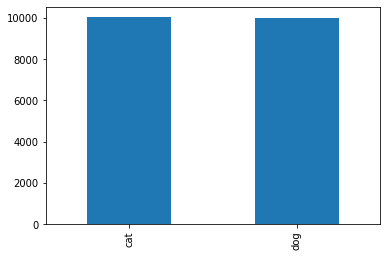

In [11]:
train_df['category'].value_counts().plot.bar() # виводить кількість даних(зображень) для навчання

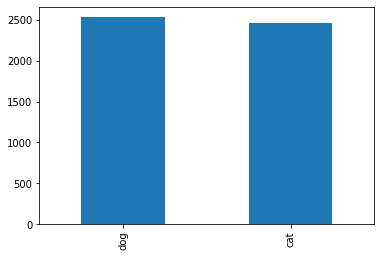

In [12]:
validate_df['category'].value_counts().plot.bar() # виводить кількість даних(зображень) для навчання (валідація)

In [13]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
# ImageDataGenerator - обробка фото
# rotation_range=15 - діапазон градусів для випадкових обертів.
# rescale=1./255 - помножимо дані (піксель) на надане значення. Так щоб піксель був від 0 до 1 (нормалізація пікселів)
# shear_range=0.1 - інтенсивність зсуву (кут зсуву в напрямку проти годинникової стрілки в градусах)
# zoom_range=0.2 -  діапазон для випадкового збільшення зображення
# horizontal_flip=True - випадково переверніть входи по горизонталі.
# width_shift_range=0.1 - зсув по ширині
# height_shift_range=0.1 - зсув по довжині

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)
# .flow_from_dataframe(...) - бере фрейм даних та шлях до каталогу та генерує партії доповнених / нормалізованих даних.
# train_df - Кадр даних Pandas, що містить шляхи до файлу відносно каталогу зображень у стовпці рядків
# path - шлях до фотографій
# x_col='filename' - рядок, стовпець у фреймі даних, що містить імена файлів
# y_col='category' - стовпці в кадрі даних, який містить цільові дані.
# target_size=IMAGE_SIZE - розміри, як буде змінюватись наша фотографія
# class_mode='categorical' - ???
# batch_size=batch_size - розмір пакетів даних які ми будемо брати

Found 20000 validated image filenames belonging to 2 classes.


In [15]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [16]:
# epochs=3 if FAST_RUN else 50
# history = model.fit_generator(
#     train_generator, 
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=total_validate//batch_size,
#     steps_per_epoch=total_train//batch_size,
#     callbacks=callbacks
# )

In [17]:
model = keras.models.load_model('/home/artur/Downloads/catdog2(1).h5')

In [18]:
test_filenames = os.listdir("/home/artur/Downloads/dc/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
print(nb_samples)
print(batch_size)
print(np.ceil(nb_samples/batch_size))

12500
15
834.0


In [19]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/home/artur/Downloads/dc/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size, 
    shuffle=False
)

Found 12500 validated image filenames.


In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/home/artur/Downloads/dc/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Для підготовки зображення до інпуту в нейронку
from keras.preprocessing import image

classification = ['cat', 'dog']

def predict_img(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    plt.imshow(img_tensor[0])
    plt.show()
    
    
    prediction = model.predict(img_tensor)
    print(prediction)
    top = np.argmax(prediction)
    print(classification[top])
    

file = 'cat2.jpg'
# predict_img('/home/artur/Downloads/dc/test1/' + file)
predict_img('/home/artur/Downloads/' + file)